# Prepapration du Jeux d'apprentissage

## Contexte

**Problèmatique** : Déterminer les clients qui sont VIP ou non (1 : VIP / 0 : Non VIP)

**Etapes du Projet** :
- Explorer les Datasets disponibles pour déterminer les variables potentiellements utiles pour notre modèle
- Construction du dataset d'apprentissage
- Exploration du dataset et nettoyage des données
- Réaliser des tests de corrélations et supprimer les colonnes inutiles
- Mise en place du modèle d'apprentissage 


## Import bibliothèque

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import stats_desc as st
from scipy import stats

## Chargement des datasets

In [4]:
# Load your dataset into a DataFrame
df_client = pd.read_csv("data/CLIENT.csv", sep = "|", dtype={'IDCLIENT':str, 'VIP': str})
df_ticket = pd.read_csv('data/ENTETES_TICKET_V4.csv', sep = "|", dtype={'IDTICKET':str, 'IDCLIENT' : str})
df_magasin = pd.read_csv('data/REF_MAGASIN.CSV', sep = "|",dtype={'LIBELLEDEPARTEMENT':str})




C:\Users\benja\AppData\Local\Temp\ipykernel_1728\2190855751.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_client = pd.read_csv("data/CLIENT.csv", sep = "|", dtype={'IDCLIENT':str, 'VIP': str})


In [5]:
df_client.head()

,IDCLIENT,CIVILITE,DATENAISSANCE,MAGASIN,DATEDEBUTADHESION,DATEREADHESION,DATEFINADHESION,VIP,CODEINSEE,PAYS
0,155891,MADAME,NaN,VLG,13/05/2005 0:00:00,4/04/2017 0:00:00,30/04/2018 0:00:00,0,74224,FR
1,156023,MONSIEUR,7/08/1966 0:00:00,VLG,14/05/2005 0:00:00,21/06/2014 0:00:00,30/06/2016 0:00:00,0,74189,FR
2,124203,MADAME,NaN,BEA,16/03/2005 0:00:00,12/10/2017 0:00:00,31/10/2018 0:00:00,0,63070,FR
3,156190,MADAME,24/07/1976 0:00:00,SUR,28/08/2006 0:00:00,24/05/2015 0:00:00,31/05/2016 0:00:00,0,92026,FR
4,144444,MONSIEUR,NaN,LAB,29/04/2006 0:00:00,18/12/2016 0:00:00,31/12/2017 0:00:00,0,31555,FR


## Transformation des variables

In [6]:
df_client['DATEDEBUTADHESION'] = pd.to_datetime(df_client['DATEDEBUTADHESION'], 
                                           format= '%d/%m/%Y %H:%M:%S')
df_client['DATEFINADHESION'] = pd.to_datetime(df_client['DATEFINADHESION'], 
                                             format='%d/%m/%Y %H:%M:%S')

df_ticket['TIC_TOTALTTC']=df_ticket['TIC_TOTALTTC'].str.replace(',','.')
df_ticket['TIC_TOTALTTC']=df_ticket['TIC_TOTALTTC'].astype('float')

## Construction du dataset

In [7]:
print(df_client.info())
print(df_ticket.info())
print(df_magasin.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 845876 entries, 0 to 845875
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   IDCLIENT           845876 non-null  object        
 1   CIVILITE           845876 non-null  object        
 2   DATENAISSANCE      507902 non-null  object        
 3   MAGASIN            845876 non-null  object        
 4   DATEDEBUTADHESION  845876 non-null  datetime64[ns]
 5   DATEREADHESION     507816 non-null  object        
 6   DATEFINADHESION    845876 non-null  datetime64[ns]
 7   VIP                845876 non-null  object        
 8   CODEINSEE          818455 non-null  object        
 9   PAYS               845873 non-null  object        
dtypes: datetime64[ns](2), object(8)
memory usage: 64.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6714173 entries, 0 to 6714172
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------  

In [8]:
df_sommeticket = df_ticket.groupby(['IDCLIENT']).agg(Total_ticket=('TIC_TOTALTTC',"sum")).reset_index()
df_sommeticket.head()

,IDCLIENT,Total_ticket
0,10000,813.16
1,100002,249.41
2,100004,199.57
3,100006,1626.06
4,100008,332.50


In [9]:
df_general = df_client.merge(df_sommeticket, how = 'left', left_on = 'IDCLIENT', right_on = 'IDCLIENT')
df_general = df_general.merge(df_magasin[['CODESOCIETE','LIBELLEDEPARTEMENT']], how = 'left', left_on = 'MAGASIN', right_on = 'CODESOCIETE')
df_general = df_general.drop('CODESOCIETE', axis = 1)
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 845876 entries, 0 to 845875
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   IDCLIENT            845876 non-null  object        
 1   CIVILITE            845876 non-null  object        
 2   DATENAISSANCE       507902 non-null  object        
 3   MAGASIN             845876 non-null  object        
 4   DATEDEBUTADHESION   845876 non-null  datetime64[ns]
 5   DATEREADHESION      507816 non-null  object        
 6   DATEFINADHESION     845876 non-null  datetime64[ns]
 7   VIP                 845876 non-null  object        
 8   CODEINSEE           818455 non-null  object        
 9   PAYS                845873 non-null  object        
 10  Total_ticket        770163 non-null  float64       
 11  LIBELLEDEPARTEMENT  845876 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(9)
memory usage: 83.9+ MB


## Analyse du dataset

### Proportion Initial de VIP avant cleaning

In [10]:
#Proportion VIP 
comptage = round((((df_general['VIP'] == '1').sum())/df_general.shape[0])*100,2)


print("la proportion de VIP est de {} %".format(comptage))

la proportion de VIP est de 13.06 %


 ### Nombre de lignes

In [11]:
Nb_ligne_init=df_general.shape[0]
print(Nb_ligne_init)

845876


 ### Détail des Valeurs manquantes

In [12]:
df_general.isna().sum()

IDCLIENT                   0
CIVILITE                   0
DATENAISSANCE         337974
MAGASIN                    0
DATEDEBUTADHESION          0
DATEREADHESION        338060
DATEFINADHESION            0
VIP                        0
CODEINSEE              27421
PAYS                       3
Total_ticket           75713
LIBELLEDEPARTEMENT         0
dtype: int64

### Statistique descriptif qualitatif

In [13]:
colonne_qualit=df_general.drop('Total_ticket',axis=1)
print(colonne_qualit.describe())
print(st.get_stats_quali(colonne_qualit))

C:\Users\benja\AppData\Local\Temp\ipykernel_1728\1117807420.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(colonne_qualit.describe())
C:\Users\benja\AppData\Local\Temp\ipykernel_1728\1117807420.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(colonne_qualit.describe())


       IDCLIENT CIVILITE      DATENAISSANCE MAGASIN    DATEDEBUTADHESION  \
count    845876   845876             507902  845876               845876   
unique   845876        6              27869      67                 6356   
top      155891   MADAME  1/10/1970 0:00:00     PRI  2001-03-01 00:00:00   
freq          1   454862                680   26935                10214   
first       NaN      NaN                NaN     NaN  1997-01-01 00:00:00   
last        NaN      NaN                NaN     NaN  2017-12-31 00:00:00   

           DATEREADHESION      DATEFINADHESION     VIP CODEINSEE    PAYS  \
count              507816               845876  845876    818455  845873   
unique               2860                  161       2     24442      48   
top     8/04/2017 0:00:00  2018-05-31 00:00:00       0     13001      FR   
freq                 2149                56297  735425      9174  827365   
first                 NaN  2016-01-21 00:00:00     NaN       NaN     NaN   
last       

g:\Mon Drive\cours benjamin\ESG Paris\Cours\Semestre 2\Machine learning\Machine learning - Projet\Projet git\stats_desc.py:61: FutureWarning: ['DATENAISSANCE', 'DATEREADHESION', 'CODEINSEE', 'PAYS'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  stats1 = df.agg(['nunique', 'min', 'max']).transpose()


### Statistique descriptif quantitatif

In [14]:
colonne_quanti=df_general[['Total_ticket']]
print(colonne_quanti.describe())
print(st.get_stats_quanti(colonne_quanti))

        Total_ticket
count  770163.000000
mean      506.980242
std       691.570828
min     -1187.880000
25%       131.720000
50%       281.950000
75%       616.235000
max     75593.440000
                dtype      min       max        mean         std  median  \
Total_ticket  float64 -1187.88  75593.44  506.980242  691.570828  281.95   

               taux_na  taux_var  
Total_ticket  0.089508  1.364098  


In [15]:
print('le quantile à 99 % est {}:'.format(colonne_quanti.quantile(0.99)))

le quantile à 99 % est Total_ticket    3240.0728
Name: 0.99, dtype: float64:


#### Analyse et cleaning à faire

- 6 valeurs uniques dans civilite à réduire à 2 
- Supprimer la colonne manquante datenaissance car trop de valeur manquante et valeur (45%)
- tranformer date readhesion en booléen
- Supprimer la colonne manquante code insee car valeur manquante et fait doublon avec département magasin
- Recadrer les valeurs de tic_total (suppresion valeur inf à 0 et supérieur à 4000)
- récupérer juste mois et année pour les dates

 ## Cleaning du dataset

### Transformation civilite

In [16]:
df_general['CIVILITE'].unique()

array(['MADAME', 'MONSIEUR', 'monsieur', 'madame', 'Mme', 'Mr'],
      dtype=object)

In [17]:
list_to_replace =['Mr','monsieur']
df_general['CIVILITE'].replace(list_to_replace, 'MONSIEUR', inplace=True)
list_to_replace =['Mme','madame']
df_general['CIVILITE'].replace(list_to_replace, 'MADAME', inplace=True)
df_general['CIVILITE'].unique()

array(['MADAME', 'MONSIEUR'], dtype=object)

### Transformation date en mois /année

In [18]:
df_general['Mois_DATEDEBUTADHESION']= df_general['DATEDEBUTADHESION'].dt.month
df_general['Annee_DATEDEBUTADHESION']= df_general['DATEDEBUTADHESION'].dt.year
df_general['Mois_DATEFINADHESION']= df_general['DATEFINADHESION'].dt.month
df_general['Annee_DATEFINADHESION']= df_general['DATEFINADHESION'].dt.year
df_general=df_general.drop('DATEFINADHESION',axis=1)
df_general=df_general.drop('DATEDEBUTADHESION',axis=1)

df_general['Mois_DATEDEBUTADHESION']=df_general['Mois_DATEDEBUTADHESION'].astype('str')
df_general['Annee_DATEDEBUTADHESION']=df_general['Annee_DATEDEBUTADHESION'].astype('str')
df_general['Mois_DATEFINADHESION']=df_general['Mois_DATEFINADHESION'].astype('str')
df_general['Annee_DATEFINADHESION']=df_general['Annee_DATEFINADHESION'].astype('str')

### Transformation readhesion en binaire

In [19]:

df_general['DATEREADHESION'] = df_general['DATEREADHESION'].fillna(0)
df_general['DATEREADHESION'] = df_general['DATEREADHESION'].apply(lambda x: 1 if x != 0 else 0)
print(df_general['DATEREADHESION'].value_counts())

1    507816
0    338060
Name: DATEREADHESION, dtype: int64


### Suppression colonne naissance et code INSEE

In [20]:
df_general=df_general.drop('DATENAISSANCE',axis=1)
df_general=df_general.drop('CODEINSEE',axis=1)

### Redimensionnement total ticket

In [21]:
filtre = (df_general['Total_ticket'] > 0 )& (df_general['Total_ticket'] < 4000)
df_general=df_general[filtre]

### Supression Valeurs manquantes

In [22]:
df_general= df_general.dropna()

### Proportion ligne perdu 

In [23]:
Ligne_perdu= round(((Nb_ligne_init-df_general.shape[0])/Nb_ligne_init)*100,2)
print(Ligne_perdu)


9.48


### Proportion VIP après Cleaning

In [24]:
#Proportion VIP 
comptage = round((((df_general['VIP'] == '1').sum())/df_general.shape[0])*100,2)

print("la proportion de VIP est de {} %".format(comptage))

la proportion de VIP est de 13.89 %


## Etude des Corrélations

### Corrélation Quali X Quali

In [25]:
colonne_qualit=df_general.drop('Total_ticket',axis=1)
# Sélectionner la colonne fixe
colonne_fixe = colonne_qualit['VIP']

# Parcourir toutes les autres colonnes
for nom_colonne in colonne_qualit.columns:
    if nom_colonne != 'VIP':
        # Sélectionner la colonne à analyser
        colonne_analyse = colonne_qualit[nom_colonne]
        
        # Créer un tableau de contingence entre les deux colonnes
        table_contingence = pd.crosstab(colonne_fixe, colonne_analyse)
        
        # Effectuer le test Chi2 et afficher le résultat
        stat, p, dof, expected = stats.chi2_contingency(table_contingence)
        print(f'Corrélation chi2 entre {colonne_fixe.name} et {nom_colonne}: p = {p}')

Corrélation chi2 entre VIP et IDCLIENT: p = 0.49946268602311394
Corrélation chi2 entre VIP et CIVILITE: p = 8.966880751254814e-17
Corrélation chi2 entre VIP et MAGASIN: p = 0.0
Corrélation chi2 entre VIP et DATEREADHESION: p = 0.0
Corrélation chi2 entre VIP et PAYS: p = 7.026636357105466e-53
Corrélation chi2 entre VIP et LIBELLEDEPARTEMENT: p = 0.0
Corrélation chi2 entre VIP et Mois_DATEDEBUTADHESION: p = 1.4901225991437774e-306
Corrélation chi2 entre VIP et Annee_DATEDEBUTADHESION: p = 0.0
Corrélation chi2 entre VIP et Mois_DATEFINADHESION: p = 0.0
Corrélation chi2 entre VIP et Annee_DATEFINADHESION: p = 0.0


### Corrélation Quali X Quanti

<AxesSubplot: xlabel='VIP', ylabel='Total_ticket'>

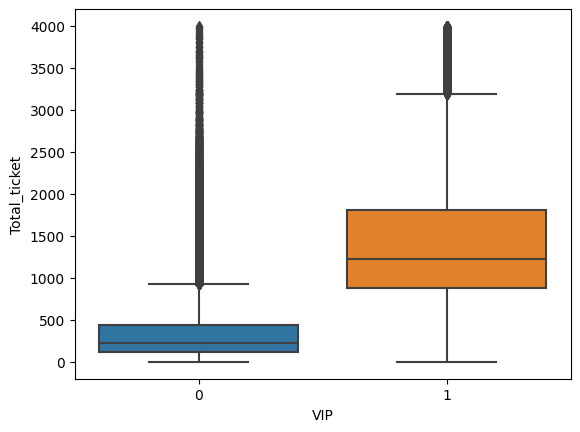

In [26]:
sns.boxplot(x=df_general['VIP'],y=df_general['Total_ticket'],data=df_general)

### Visualisation des variables qui ont la meilleure corrélation avec  la colonne VIP

C:\Users\benja\AppData\Local\Temp\ipykernel_1728\1733965797.py:20: RuntimeWarning: divide by zero encountered in double_scalars
  cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


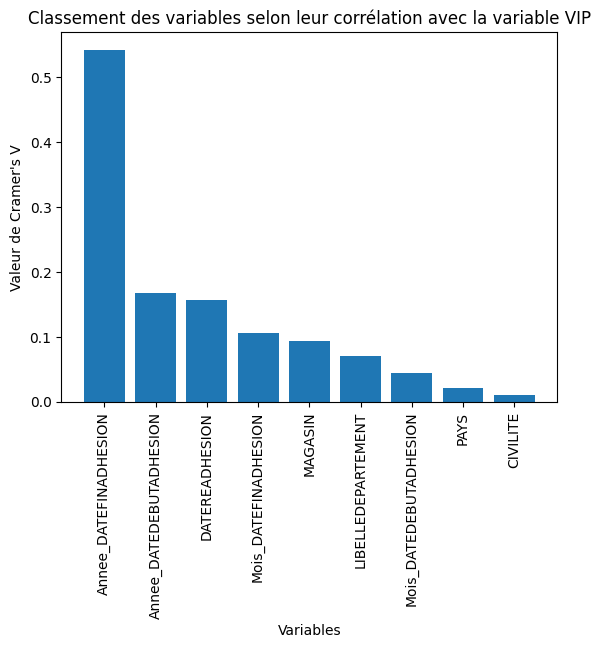

In [27]:
# Spécifier la variable cible
target_variable = 'VIP'

# Initialiser une liste vide pour stocker les résultats du test de Cramer's V
cramer_results = []

# Boucle à travers toutes les colonnes du dataframe
for column in colonne_qualit.columns:
    # Vérifier si la colonne est catégorielle
    if column != target_variable :
        # Effectuer le test de Cramer's V pour la colonne et la variable cible
        contingency_table = pd.crosstab(colonne_qualit[column], colonne_qualit[target_variable])
        chi2_stat, p_val, dof, expected = stats.chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        phi2 = chi2_stat/n
        r, k = contingency_table.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        cramers_v = np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
        
        # Ajouter le résultat du test de Cramer's V à la liste
        cramer_results.append({'Variable': column, 'Cramer\'s V': cramers_v})

# Trier la liste des résultats du test de Cramer's V par ordre décroissant de corrélation
cramer_results = sorted(cramer_results, key=lambda x: x['Cramer\'s V'], reverse=True)

# Extraire les noms de variables et les valeurs de Cramer's V en tant que listes
variable_names = [result['Variable'] for result in cramer_results]
cramer_values = [result['Cramer\'s V'] for result in cramer_results]

# Créer un histogramme des valeurs de Cramer's V
plt.bar(variable_names, cramer_values)
plt.xticks(rotation=90)
plt.title("Classement des variables selon leur corrélation avec la variable VIP")
plt.xlabel("Variables")
plt.ylabel("Valeur de Cramer's V")
plt.show()

### Suppression des Variables : Pays / Civilités / IDCLIENT

In [28]:
df_general=df_general.drop(['IDCLIENT','PAYS','CIVILITE'],axis=1)
df_general.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 765652 entries, 0 to 845867
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   MAGASIN                  765652 non-null  object 
 1   DATEREADHESION           765652 non-null  int64  
 2   VIP                      765652 non-null  object 
 3   Total_ticket             765652 non-null  float64
 4   LIBELLEDEPARTEMENT       765652 non-null  object 
 5   Mois_DATEDEBUTADHESION   765652 non-null  object 
 6   Annee_DATEDEBUTADHESION  765652 non-null  object 
 7   Mois_DATEFINADHESION     765652 non-null  object 
 8   Annee_DATEFINADHESION    765652 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 58.4+ MB


# Mise en place de du modèle d'apprentissage : Régression Logistique

## Import bibliothèque

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve,RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV


## Séparation de la variable cible des variables d'entrées

In [30]:
#Variables d'entrées
x = df_general.drop('VIP',axis=1)
#Variable Cible
y = df_general[['VIP']]

## Transformation des variables qualitatives en variables binaires (Dummification)

In [31]:
x=pd.DataFrame(pd.get_dummies(x))

## Séparation Test / entrainement

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=123
)

## Normalisation des données quanti

In [33]:
#scaler = StandardScaler()
#X_train= scaler.fit_transform(X_train) # transformez les données d'entraînement
#X_test= scaler.transform(X_test)


## Aplication du modèle d'apprentissage

In [34]:
# Define parameters: these will need to be tuned to prevent overfitting and underfitting
# Define parameter grid

param_grid = {'penalty' : ['l2', 'elasticnet', 'none'],
    'C' : [0.001,0.01,0.1,1,10,100],
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 500]
    }

# Define logistic regression model
clf = LogisticRegression(random_state=123)

# Define grid search object
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

# Train the classifer on the train set
clf = grid_search.fit(X_train, y_train)

# Print best parameters and score
print("Best parameters: ", clf.best_params_)
print("Best score: ", clf.best_score_)


# Predict the outcomes on the test set
y_pred = clf.predict(X_test)

Fitting 5 folds for each of 180 candidates, totalling 900 fits


## Evaluation du modèle

### Score Accuracy et AUC

In [ ]:

##### Evalulation du modèle
print('Accuracy sur train = ', clf.score(X_train, y_train))  
print('Accuracy sur test = ', clf.score(X_test, y_test)) 
###### AUC
print('AUC sur train = ', roc_auc_score(y_train, clf.predict(X_train)))  
print('AUC sur test = ', roc_auc_score(y_test, clf.predict(X_test))) 

Accuracy sur train =  0.9456202034344585
Accuracy sur test =  0.9453015207953482
AUC sur train =  0.8562049315623212
AUC sur test =  0.8561965088805635


Conclusion pas d'Overfitting

### Matrice de confusion

Text(0.5, 23.52222222222222, 'Predicted label')

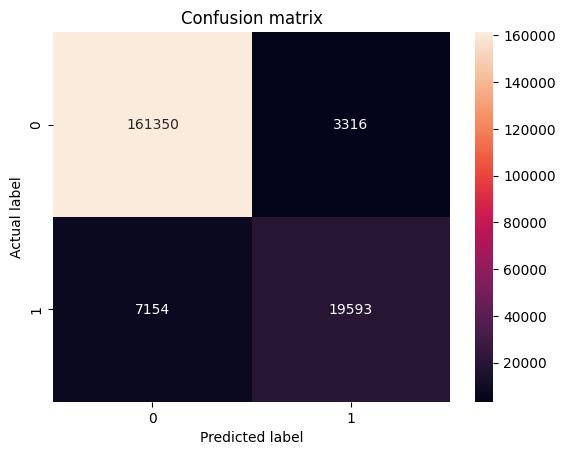

In [ ]:
# Calculate confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot a labeled confusion matrix with Seaborn
sns.heatmap(cnf_matrix, annot=True, fmt="g")
plt.title("Confusion matrix")
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

### Metrics sur le jeux de test et courbe ROC

Precision: 0.8552533938626741
Recall: 0.7325307511122743
F1 score: 0.7891493475108748


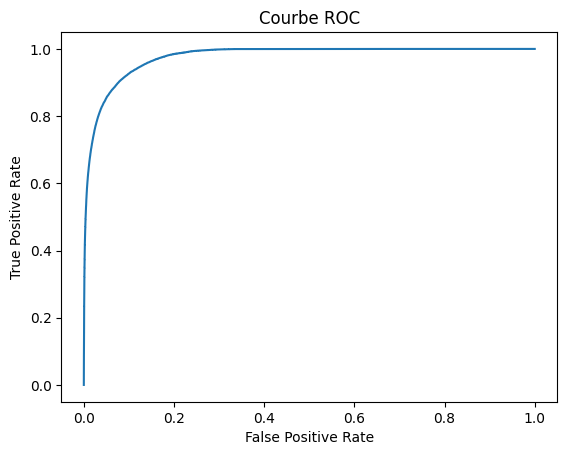

In [ ]:
# Faire des prédictions sur les données de test
y_pred = clf.predict(X_test)

# Calculer les scores d'évaluation
precision = precision_score(y_test, y_pred,pos_label='1')
recall = recall_score(y_test, y_pred,pos_label='1')
f1 = f1_score(y_test, y_pred,pos_label='1')
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1],pos_label='1')

print("Precision:", precision)
print("Recall:", recall)
print("F1 score:", f1)

# Afficher la courbe ROC
import matplotlib.pyplot as plt
plt.plot(fpr, tpr)
plt.title('Courbe ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()